In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch.jit
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import timesead
import matplotlib.widgets as widgets
import itertools
import time
from torch.utils.data import DataLoader, TensorDataset
from timesead.models.prediction.tcn_prediction import TCNPredictionAnomalyDetector
from timesead.models.reconstruction.lstm_ae import LSTMAEAnomalyDetector, LSTMAEMirza2018
from timesead.models.reconstruction.tcn_ae import TCNAEAnomalyDetector, TCNAE
from timesead.models.generative.omni_anomaly import OmniAnomaly, OmniAnomalyDetector, OmniAnomalyLoss
from timesead.models.prediction.tcn_prediction import TCNPrediction, TCNPredictionAnomalyDetector
import datapreparation as moduleprep
from datapreparation import MethodChooser, UpstreamDataPreparation, df2, df3

In [78]:
#Test fichier in Ordnung
detector = UpstreamDataPreparation(method="IQR", seq_length=50, scale_method="standard", interpolation_method = "linear") #threshold, interpolation_method=... si besoin

df_new, anomalies_moteur = detector.preprocess_data(moduleprep.df2)

# Convertir temporairement en 2D pour l'analyse
df_for_analysis = df_new.copy()
if len(df_for_analysis.shape) == 3:
    df_for_analysis = df_for_analysis.reshape(-1, df_for_analysis.shape[-1])


# Analyser les caractéristiques du dataset
dataset_info = MethodChooser.analyze_dataset(df_for_analysis.to_numpy())

# Sélection automatique du modèle optimal
selected_model = MethodChooser.select_best_model(
    df_for_analysis.to_numpy(),
    labels_available=dataset_info["labels_available"],
    anomaly_type=dataset_info["anomaly_type"],
    real_time=dataset_info["real_time"]
)


#Selection manuelle du modèle
#selected_model = MethodChooser.select_best_model(df_for_analysis.to_numpy(), forced_model="tcn_prediction")

print(f"Modèle automatiquement sélectionné pour i.O: {selected_model}")

# Exécuter le pipeline complet AVEC le modèle sélectionné
X_train_tensor, X_test_tensor, anomalies_moteur = detector.process(df2, model_name=selected_model)

# Vérification finale des tenseurs
print(f"Forme finale de X_train_tensor : {X_train_tensor.shape}")
print(f"Forme finale de X_test_tensor : {X_test_tensor.shape}")

Détection des anomalies moteur en cours...
Ratio de NaN (2.11%) supérieur au seuil de 2%, interpolation appliquée.
Nombre total d'anomalies moteur détectées : 18998
Nombre total de valeurs dans le fichier : 905667
Ratio anomalies / total valeurs nettoyées : 2.10%
Nombre total de valeurs après nettoyage : 905667
 Modèle sélectionné : tcn_prediction (TCNPredictionAnomalyDetector)
 TCNPredictionAnomalyDetector instancié avec input_dim=49, window_size=50
Modèle automatiquement sélectionné pour i.O: TCNPredictionAnomalyDetector(
  (model): TCNPrediction(
    (activation): ReLU()
    (pooler): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layers): ModuleList(
      (0): Conv1d(49, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
    )
    (mlp): MLP(
      (activation): ReLU()
      (layers): ModuleList(
        (0): Linear(in_features=384, out_features=50, bias=True)
        (1): Li

In [79]:
#Test fichier Nicht in Ordnung
df_nio, anomalies_moteur_nio = detector.preprocess_data(df3)
df_for_analysis3 = df_nio.copy()
if len(df_for_analysis3.shape) == 3:
    df_for_analysis3 = df_for_analysis3.reshape(-1, df_for_analysis.shape[-1])
dataset_info3 = MethodChooser.analyze_dataset(df_for_analysis3.to_numpy())
selected_model3 = MethodChooser.select_best_model(
    df_for_analysis3.to_numpy(),
    labels_available=dataset_info3["labels_available"],
    anomaly_type=dataset_info3["anomaly_type"],
    real_time=dataset_info3["real_time"]
)
print(f"Modèle automatiquement sélectionné pour n.i.O: {selected_model3}")
X_train_tensor_nio, X_test_tensor_nio, anomalies_moteur_nio = detector.process(df3, model_name=selected_model3)
print(f"Forme finale de X_train_tensor : {X_train_tensor_nio.shape}")
print(f"Forme finale de X_test_tensor : {X_test_tensor_nio.shape}")

Détection des anomalies moteur en cours...
Ratio de NaN (2.13%) supérieur au seuil de 2%, interpolation appliquée.
Nombre total d'anomalies moteur détectées : 17621
Nombre total de valeurs dans le fichier : 832095
Ratio anomalies / total valeurs nettoyées : 2.12%
Nombre total de valeurs après nettoyage : 832095
 Modèle sélectionné : tcn_prediction (TCNPredictionAnomalyDetector)
 TCNPredictionAnomalyDetector instancié avec input_dim=45, window_size=50
Modèle automatiquement sélectionné pour n.i.O: TCNPredictionAnomalyDetector(
  (model): TCNPrediction(
    (activation): ReLU()
    (pooler): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layers): ModuleList(
      (0): Conv1d(45, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
    )
    (mlp): MLP(
      (activation): ReLU()
      (layers): ModuleList(
        (0): Linear(in_features=384, out_features=50, bias=True)
        (1): 

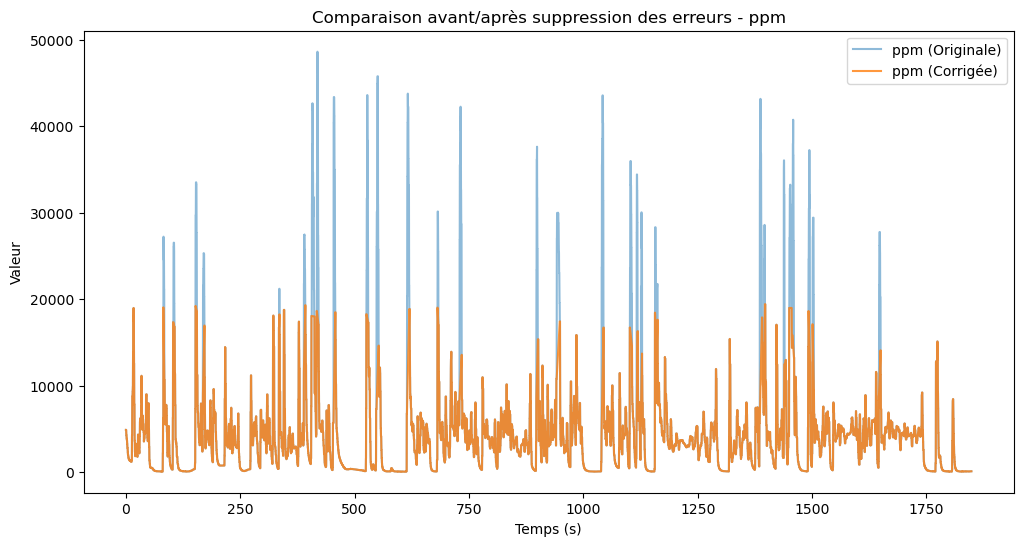

In [59]:
#COMPARE GRAPHIQUE FEATURE AVANT ET APRES SUPPRESSION
feature = "ppm" #feature a changer si besoin
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2[feature], label=f"{feature} (Originale)", alpha=0.5)
plt.plot(df_new.index, df_new[feature], label=f"{feature} (Corrigée)", alpha=0.8)
plt.xlabel("Temps (s)")
plt.ylabel("Valeur")
plt.legend()
plt.title(f"Comparaison avant/après suppression des erreurs - {feature}")
plt.show()

In [60]:
df_new.info() #POUR CONFIRMER QU IL N Y A BIEN PLUS DE NAN

<class 'pandas.core.frame.DataFrame'>
Index: 18483 entries, 0.0 to 1848.2
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rpm     18483 non-null  float64
 1   Nm      18483 non-null  float64
 2   %       18483 non-null  float64
 3   °C      18483 non-null  float64
 4   °C.1    18483 non-null  float64
 5   hPa     18483 non-null  float64
 6   %.1     18483 non-null  float64
 7   mm      18483 non-null  float64
 8   °       18483 non-null  float64
 9   °.1     18483 non-null  float64
 10  -       18483 non-null  float64
 11  -.1     18483 non-null  float64
 12  mbar    18483 non-null  float64
 13  hPa.1   18483 non-null  float64
 14  kg/h    18483 non-null  float64
 15  °CRK    18483 non-null  float64
 16  ms      18483 non-null  float64
 17  µs      18483 non-null  float64
 18  °CRK.1  18483 non-null  float64
 19  °CRK.2  18483 non-null  float64
 20  °.2     18483 non-null  float64
 21  °CRK.3  18483 non-null  float64
 22  

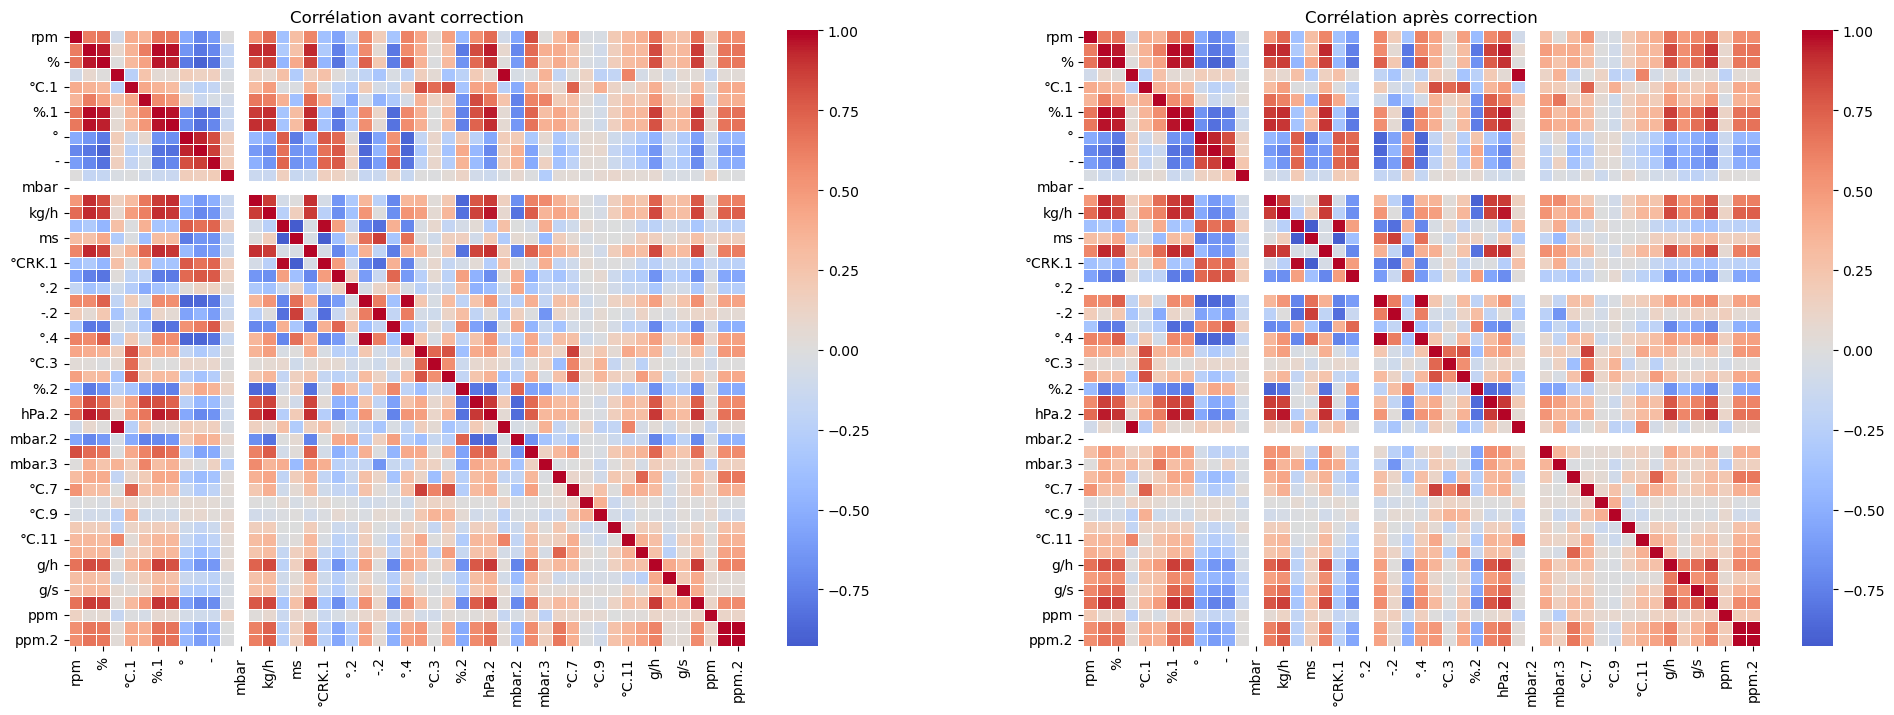

In [61]:
#Genere heatmap donnees nettoyees
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
sns.heatmap(df2.corr(), annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Corrélation avant correction")
    
plt.subplot(1, 2, 2)
sns.heatmap(df_new.corr(), annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Corrélation après correction")
    
plt.show()

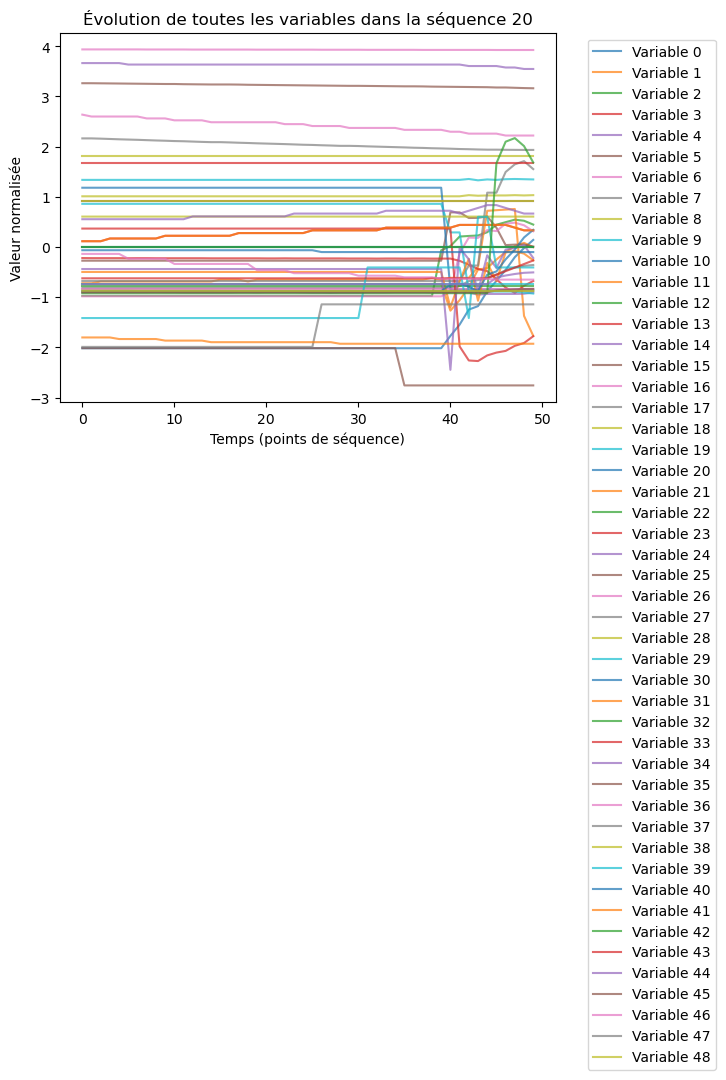

In [62]:
#AFFICHE LES VALEURS NORMALISEES EN FONCTION D'UNE SEQUENCE
if isinstance(X_train_tensor, torch.Tensor):
    X_train_np = X_train_tensor.cpu().detach().numpy()  # Convertir en numpy (ajouter .cpu() si sur GPU)
else:
    X_train_np = X_train_tensor  # Si déjà NumPy, pas besoin de conversion
# Sélection d'une séquence spécifique pour affichage (exemple : première séquence)
sequence_index = 20  # Modifier pour voir d'autres séquences
data_sample = X_train_np[sequence_index]  # Sélection de la séquence

# Sélection d'une variable à afficher (exemple : première variable)
variable_index = 1  # Modifier pour voir d'autres variables
time_axis = np.arange(data_sample.shape[0])  # Axe temporel
for variable_index in range(data_sample.shape[1]):  # Boucle sur toutes les variables (colonnes)
    plt.plot(time_axis, data_sample[:, variable_index], label=f"Variable {variable_index}", alpha=0.7)

plt.title(f"Évolution de toutes les variables dans la séquence {sequence_index}")
plt.xlabel("Temps (points de séquence)")
plt.ylabel("Valeur normalisée")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Déplacer la légende pour éviter le chevauchement
plt.show()

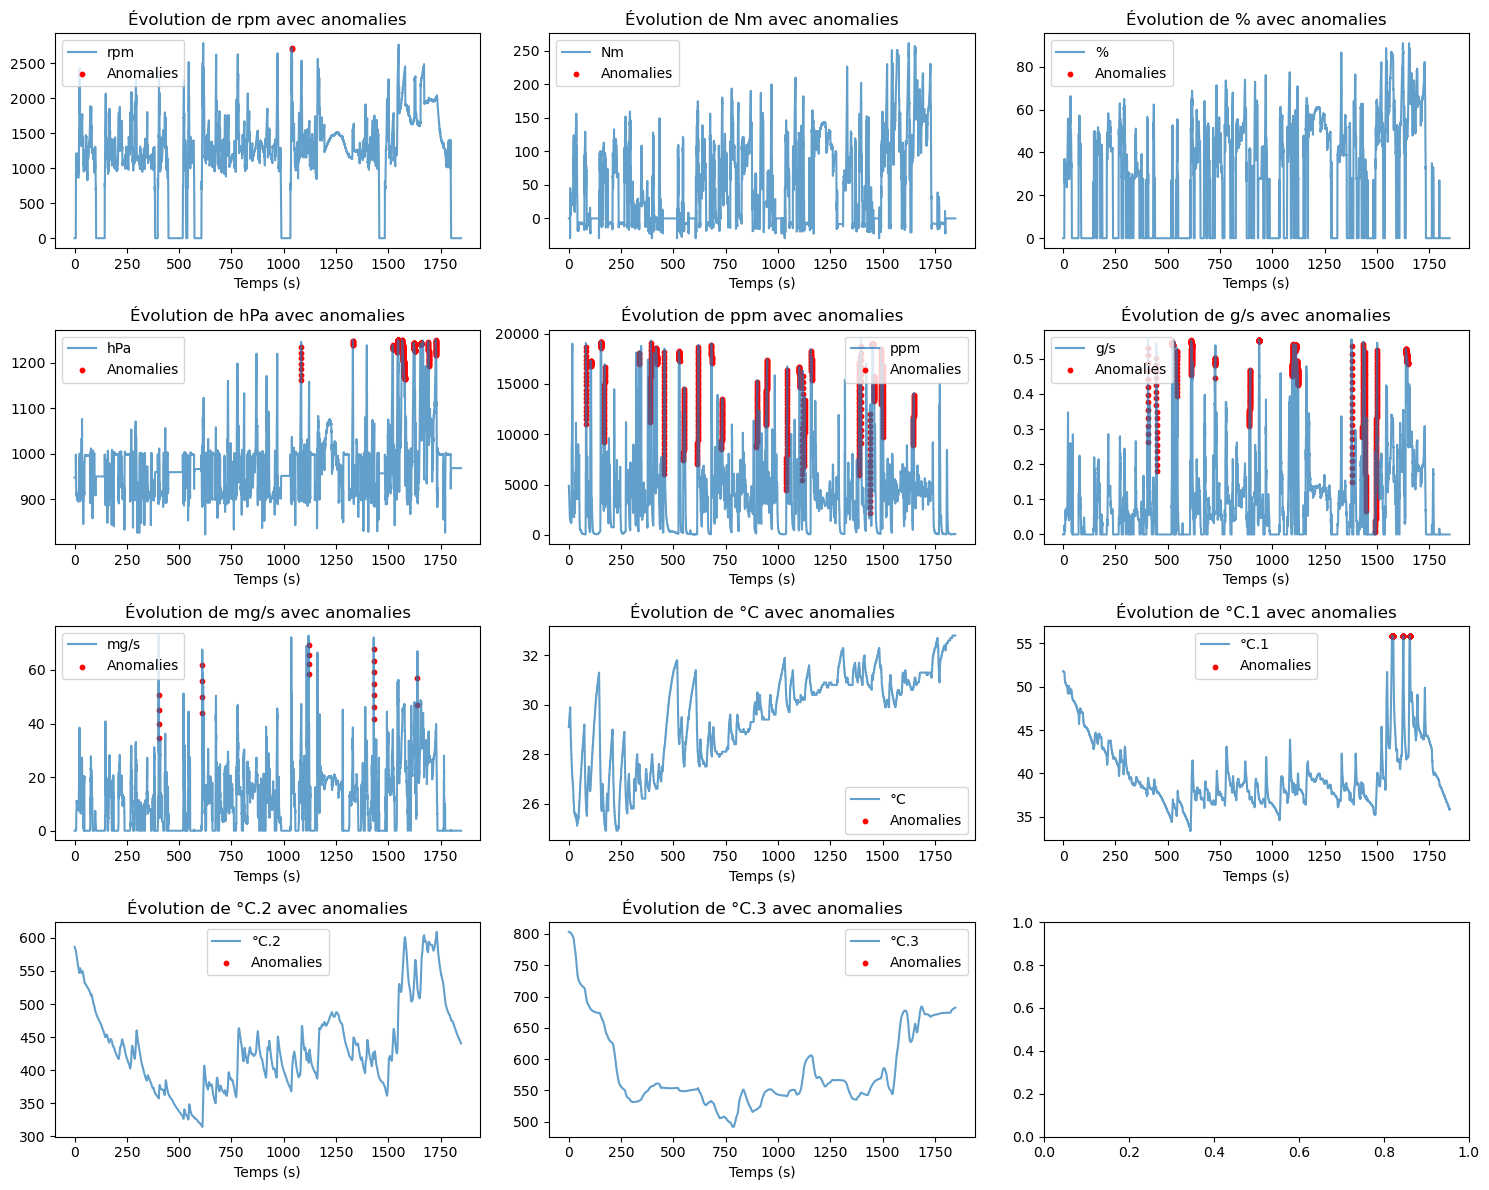

In [63]:
#AFFICHE LES ANOMALIES POUR CHAQUE FEATURES 
variables_cibles = ["rpm", "Nm", "%", "hPa", "ppm", "g/s", "mg/s", "°C", "°C.1", "°C.2", "°C.3"]

# Création d'un subplot pour chaque variable
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(variables_cibles):
    if var in df_new.columns:
        # Tracer la courbe complète
        axes[i].plot(df_new.index, df_new[var], label=var, alpha=0.7)
        
        # Identifier les anomalies (et vérifier si elles existent)
        if var in anomalies_moteur.columns:
            anomaly_indices = anomalies_moteur.index[anomalies_moteur[var].fillna(False)]
            anomaly_indices = anomaly_indices[anomaly_indices.isin(df_new.index)]  # Filtrage des indices valides
            
            axes[i].scatter(anomaly_indices, df_new.loc[anomaly_indices, var], 
                            color='red', s=10, label="Anomalies")

        # Améliorer l'affichage
        axes[i].set_title(f"Évolution de {var} avec anomalies")
        axes[i].set_xlabel("Temps (s)")
        axes[i].legend()

# Ajustement automatique des sous-graphiques
plt.tight_layout()
plt.show()

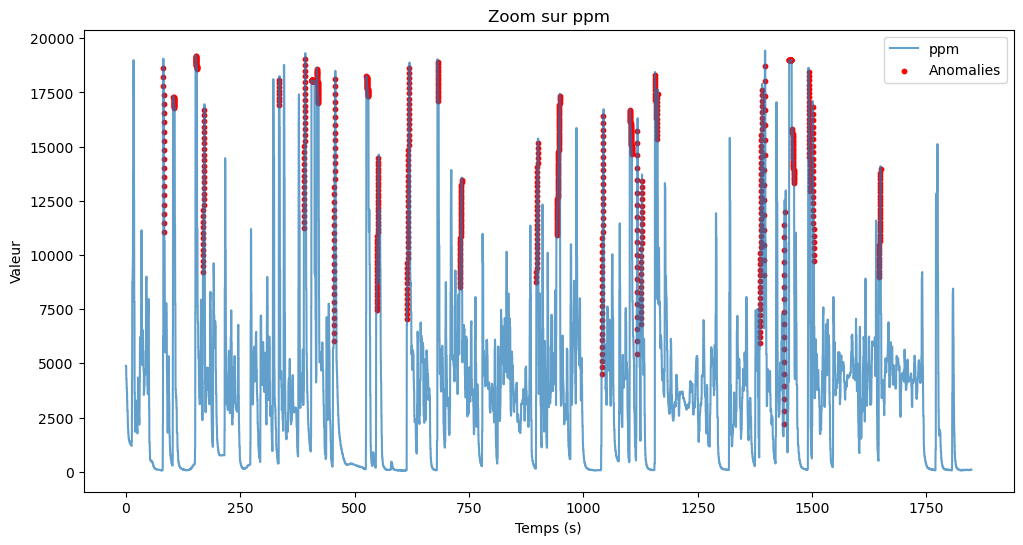

In [64]:
#AFFICHE LES ANOMALIES POUR UNE FEATURE A RENSEIGNER
fig, ax = plt.subplots(figsize=(12, 6))

#Changer la colonne a afficher
variable = "ppm"

ax.plot(df_new.index, df_new[variable], label=variable, alpha=0.7)

if variable in anomalies_moteur.columns:
    anomaly_indices = anomalies_moteur.index[anomalies_moteur[variable].fillna(False)]
    anomaly_indices = anomaly_indices[anomaly_indices.isin(df_new.index)]
    ax.scatter(anomaly_indices, df_new.loc[anomaly_indices, variable], 
               color='red', s=10, label="Anomalies")

ax.set_title(f"Zoom sur {variable}")
ax.set_xlabel("Temps (s)")
ax.set_ylabel("Valeur")
ax.legend()

In [49]:
# Collate function adaptée pour TCNPrediction :
def collate_fn_tcn(batch):
    """
    Construit les batches pour TCNPrediction.
    Chaque entrée est de forme (B, T, D) et la cible correspond au dernier pas de temps : (B, D)
    """
    xs, ys = zip(*batch)
    xs = torch.stack(xs)  # (B, T, D)
    ys = torch.stack(ys)  # (B, D)
    return xs, ys

class TCNPredictionTester:
    """
    Cette classe permet de :
      1. Optimiser les hyperparamètres d'un modèle TCNPrediction via un split train/test.
      2. Tester le modèle sur le jeu de test en calculant la loss (entre la prédiction et la cible).
      3. Visualiser le score d'anomalie (calculé sur le dernier pas de temps de chaque fenêtre de X_test).
    
    On suppose que :
      - Le modèle TCNPrediction est encapsulé dans un TCNPredictionAnomalyDetector.
      - Les tenseurs d'entraînement et de test sont de forme (N, T, D) et que la cible est le dernier pas de temps.
    """
    
    def __init__(self, X_train, X_test):
        """
        Parameters
        ----------
        X_train : torch.Tensor
            Tenseur d'entraînement de forme (N, T, D)
        X_test : torch.Tensor
            Tenseur de test de forme (N, T, D)
        """
        self.X_train = X_train
        self.X_test = X_test
        self.input_dim = X_train.shape[-1]
        self.window_size = X_train.shape[1]  # Longueur de la séquence
    
    def optimize_hyperparameters(self):
        """
        Recherche sur une grille d'hyperparamètres (par exemple, 'filters' et 'kernel_sizes')
        et choisit la configuration qui minimise la loss sur le jeu de test.
        
        Retourne
        -------
        best_model : Le modèle TCNPredictionAnomalyDetector entraîné avec la meilleure configuration.
        best_params : dict des meilleurs hyperparamètres.
        best_loss : float, la loss correspondante.
        """
        param_grid = {
            'filters': [ (32, 32), (64, 64) ], #2 couches suffisent pour des fenetres de 50 pas
            'kernel_sizes': [ (3, 3), (5, 3) ],
            'linear_hidden_layers': [ (50,), (100, 50) ],
            'activation': [ torch.nn.ReLU(), torch.nn.LeakyReLU() ],
            'learning_rate': [1e-3]
        }

        best_loss = float('inf')
        best_params = None
        best_model = None
        collate_fn = collate_fn_tcn  # fonction de collate pour TCN

        # Préparation des DataLoaders pour l'entraînement et le test.
        # La cible correspond au dernier pas de temps de chaque séquence.
        train_dataset = TensorDataset(
            self.X_train, 
            self.X_train[:, -1, :]  # cible : dernier pas de temps
        )
        test_dataset = TensorDataset(
            self.X_test, 
            self.X_test[:, -1, :]
        )
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
    
        for params in itertools.product(*param_grid.values()):
            param_dict = dict(zip(param_grid.keys(), params))
            start_time = time.time()

            # Instanciation du modèle TCNPrediction avec la configuration courante.
            # On fixe ici prediction_horizon=1 pour prédire le dernier pas.
            base_model = TCNPrediction(
                input_dim=self.input_dim,
                window_size=self.window_size,
                filters=param_dict['filters'],
                kernel_sizes=param_dict['kernel_sizes'],
                prediction_horizon=1
            )
            detector = TCNPredictionAnomalyDetector(base_model)
            
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(detector.model.parameters(), lr=1e-3)
            
            # Entraînement (par exemple, 5 époques)
            detector.model.train()
            for epoch in range(5):
                for batch, target in train_loader:
                    x = batch  # x de forme (B, T, D)
                    optimizer.zero_grad()
                    # Prédiction : attend (B, 1, D)
                    output = detector.model((x,))
                    if isinstance(output, tuple):
                        output = output[0]
                    loss = criterion(output.squeeze(1), target)
                    loss.backward()
                    optimizer.step()
            
            # Calcul des statistiques sur le jeu d'entraînement (pour le scoring d'anomalie)
            detector.model.eval()
            all_errors = []
            with torch.no_grad():
                for batch, target in train_loader:
                    x = batch
                    output = detector.model((x,))
                    # Calcul de l'erreur entre la cible et la prédiction
                    error = torch.abs(target - output.squeeze(1))  # forme (B, D)
                    all_errors.append(error)
            all_errors = torch.cat(all_errors, dim=0)  # (N, D)
            # Calcul de la moyenne sur le dernier pas (vecteur de forme (D,))
            detector.mean = all_errors.mean(dim=0)
            # Centrer les erreurs et calculer la matrice de covariance
            errors_centered = all_errors - detector.mean.unsqueeze(0)
            cov = torch.matmul(errors_centered.T, errors_centered) / (errors_centered.shape[0] - 1)
            # Pour la stabilité numérique, ajouter une petite valeur sur la diagonale
            cov.diagonal().add_(1e-5)
            detector.precision = torch.inverse(cov)
            
            # Évaluation sur le jeu de test
            detector.model.eval()
            total_loss = 0
            with torch.no_grad():
                for batch, target in test_loader:
                    x = batch
                    output = detector.model((x,))
                    total_loss += criterion(output.squeeze(1), target).item()
            test_loss = total_loss / len(test_loader)
            elapsed_time = time.time() - start_time
            print(f"Test Loss avec {param_dict} : {test_loss:.4f} (Temps: {elapsed_time:.2f} sec)")
            
            if test_loss < best_loss:
                best_loss = test_loss
                best_params = param_dict
                best_model = detector

        print("\n")
        print(f"Meilleurs hyperparamètres: {best_params} avec Loss {best_loss:.4f}")
        self.best_model = best_model
        self.best_params = best_params
        self.best_loss = best_loss
        return best_model, best_params, best_loss

    def test_model(self):
        """
        Teste le modèle optimisé en calculant la loss sur le jeu de test.
        Pour TCNPrediction, la cible est le dernier pas de temps de la fenêtre.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("Veuillez d'abord optimiser les hyperparamètres.")
        
        detector = self.best_model
        criterion = torch.nn.MSELoss()
        test_dataset = TensorDataset(
            self.X_test, 
            self.X_test[:, -1, :]
        )
        test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn_tcn)
        
        detector.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch, target in test_loader:
                x = batch
                output = detector.model((x,))
                total_loss += criterion(output.squeeze(1), target).item()
        test_loss = total_loss / len(test_loader)
        print(f"Loss sur l'ensemble de test : {test_loss}")
        self.test_loss = test_loss
        return test_loss

    def plot_anomaly_scores(self):
        """
        Calcule et affiche le score d'anomalie pour chaque fenêtre de X_test.
        Pour chaque fenêtre, on utilise l'erreur entre la cible (dernier pas) et la prédiction,
        corrigée par la moyenne et la covariance calculées lors de l'entraînement.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("Veuillez d'abord optimiser les hyperparamètres.")
        
        detector = self.best_model
        anomaly_scores = []
        # Pour TCNPrediction, la cible est le dernier pas de temps.
        # On itère sur chaque fenêtre de X_test.
        for i in range(len(self.X_test)):
            # Préparer la fenêtre : on conserve la forme (1, T, D)
            window = self.X_test[i].unsqueeze(0)
            with torch.no_grad():
                # Prédiction : (1, 1, D)
                pred = detector.model((window,))
            # Cible : dernier pas de temps de la fenêtre
            target = window[:, -1, :]  # (1, D)
            error = target - pred.squeeze(1)  # (1, D)
            error = error.abs()
            # Calcul du score d'anomalie : on soustrait la moyenne et on applique un produit bilinéaire
            error = error - detector.mean.unsqueeze(0)  # (1, D)
            score = F.bilinear(error, error, detector.precision.unsqueeze(0))
            anomaly_scores.append(score.squeeze().cpu().numpy())
        anomaly_scores = np.array(anomaly_scores)
        
        plt.figure(figsize=(12, 6))
        plt.plot(anomaly_scores, label="Scores d'anomalie (TCN Prediction)", color="blue", alpha=0.7)
        plt.title("Détection d'anomalies avec TCNPrediction")
        plt.xlabel("Index temporel")
        plt.ylabel("Score d'anomalie")
        plt.legend()
        plt.show()
        self.anomaly_scores = anomaly_scores
        return anomaly_scores

Test Loss avec {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (50,), 'activation': ReLU(), 'learning_rate': 0.001} : 0.1765 (Temps: 11.13 sec)
Test Loss avec {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (50,), 'activation': LeakyReLU(negative_slope=0.01), 'learning_rate': 0.001} : 0.1758 (Temps: 11.48 sec)
Test Loss avec {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (100, 50), 'activation': ReLU(), 'learning_rate': 0.001} : 0.1526 (Temps: 11.35 sec)
Test Loss avec {'filters': (32, 32), 'kernel_sizes': (3, 3), 'linear_hidden_layers': (100, 50), 'activation': LeakyReLU(negative_slope=0.01), 'learning_rate': 0.001} : 0.2085 (Temps: 11.59 sec)
Test Loss avec {'filters': (32, 32), 'kernel_sizes': (5, 3), 'linear_hidden_layers': (50,), 'activation': ReLU(), 'learning_rate': 0.001} : 0.2081 (Temps: 11.97 sec)
Test Loss avec {'filters': (32, 32), 'kernel_sizes': (5, 3), 'linear_hidden_layers': (50,), 'activation': LeakyReL

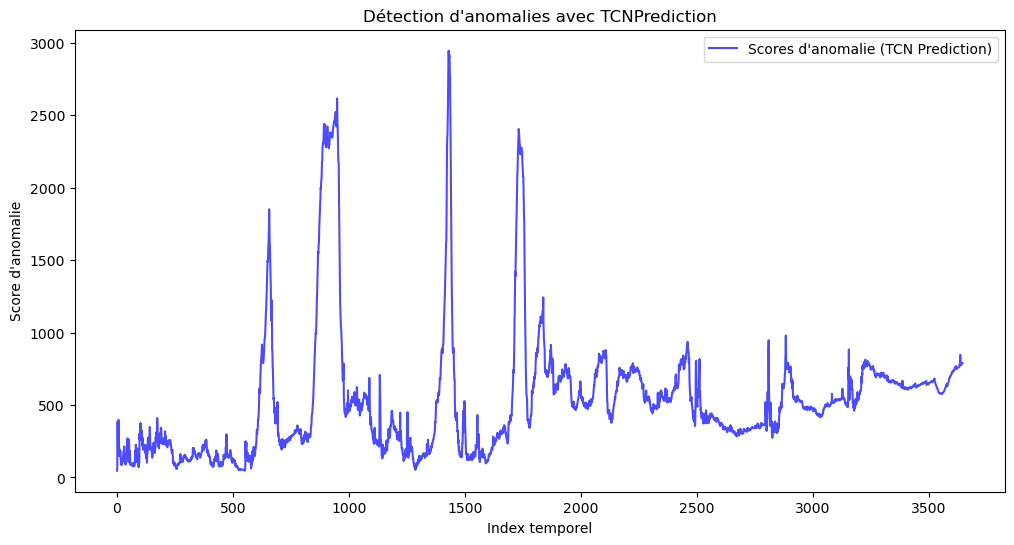

array([ 46.424553,  66.48953 , 383.74548 , ..., 785.8414  , 785.6638  ,
       789.4299  ], dtype=float32)

In [50]:
# On suppose que X_train_tensor et X_test_tensor sont déjà définis et ont la forme (N, T, D)
tester = TCNPredictionTester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

In [51]:
def collate_fn_lstm(batch):
    """ Renvoie (xs, ys) où xs et ys sont de forme (T, B, D) """
    xs, ys = zip(*batch)
    xs = torch.stack(xs).transpose(0, 1)  # (T, B, D)
    ys = torch.stack(ys).transpose(0, 1)
    return (xs,), (ys,)

def full_sequence_forward(model, x):
    """
    Passe avant adaptée pour le LSTM-AE.
    Si le modèle possède l'attribut 'model', on en extrait le tenseur (cas LSTM-AE).
    """
    # Pour LSTM-AE, x doit être de forme (T, B, D)
    if isinstance(x, tuple):
        x = x[0]
    if hasattr(model, 'model'):
        if model.training:
            hidden = model.model.encode(x)
            seq_len = x.shape[0]
            out = model.model.decoder(hidden, seq_len, x)
        else:
            with torch.no_grad():
                hidden = model.model.encode(x)
                seq_len = x.shape[0]
                out = model.model.decoder(hidden, seq_len, x)
        return out
    else:
        if not isinstance(x, tuple):
            x = (x,)
        if model.training:
            return model(x)
        else:
            with torch.no_grad():
                return model(x)

In [53]:
#CLASSE QUI TEST LSTM AE AVEC LES PARAMETRES OPTIMAUX
class LSTMAETester:
    """
    Cette classe permet de :
      1. Optimiser les hyperparamètres d'un modèle LSTM-AE via un simple split train/test.
      2. Tester le modèle avec le jeu de test et afficher la loss.
      3. Visualiser le score d'anomalie (calculé sur chaque fenêtre de X_test).
    
    On suppose que :
      - Le modèle LSTM-AE est construit via LSTMAEAnomalyDetector qui encapsule un modèle interne (LSTMAEMirza2018).
      - Le format des tenseurs d'entraînement et de test est (N, T, D).
    """
    
    def __init__(self, X_train, X_test):
        """
        Parameters
        ----------
        X_train : torch.Tensor
            Tenseur d'entraînement de forme (N, T, D)
        X_test : torch.Tensor
            Tenseur de test de forme (N, T, D)
        """
        self.X_train = X_train
        self.X_test = X_test
        self.input_dim = X_train.shape[-1]

    def optimize_hyperparameters(self):
        """
        Recherche sur une grille d'hyperparamètres (hidden_dimensions et latent_pooling)
        et choisit la configuration qui minimise la loss sur le jeu de test.
        
        Retourne
        -------
        best_model : Le modèle LSTM-AE entraîné avec la meilleure configuration.
        best_params : dict des meilleurs hyperparamètres.
        best_loss : float, la loss correspondante.
        """
        import itertools, time
        param_grid = {
            'hidden_dimensions': [[32], [64], [128]],
            'latent_pooling': ['last', 'mean']
        }
        best_loss = float('inf')
        best_params = None
        best_model = None
        collate_fn = collate_fn_lstm  # fonction de collate définie en dehors de la classe
    
        for params in itertools.product(*param_grid.values()):
            param_dict = dict(zip(param_grid.keys(), params))
            start_time = time.time()
    
            # Instanciation du modèle avec la configuration courante
            model = LSTMAEAnomalyDetector(
                LSTMAEMirza2018(input_dimension=self.input_dim, **param_dict)
            )
            
            # Création des DataLoaders pour l'entraînement et le test
            train_loader = DataLoader(
                TensorDataset(self.X_train, self.X_train),
                batch_size=32, shuffle=True, collate_fn=collate_fn
            )
            test_loader = DataLoader(
                TensorDataset(self.X_test, self.X_test),
                batch_size=32, collate_fn=collate_fn
            )
            
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            
            # Entraînement (5 époques pour accélérer)
            model.train()
            for epoch in range(5):
                for batch, _ in train_loader:
                    x = batch[0] if isinstance(batch, tuple) else batch
                    optimizer.zero_grad()
                    output = full_sequence_forward(model, x)
                    loss = criterion(output, x)
                    loss.backward()
                    optimizer.step()
            
            # Calcul des statistiques (mean et covariance) sur l'erreur du dernier pas de temps
            model.eval()
            all_errors = []
            with torch.no_grad():
                for batch, _ in train_loader:
                    x = batch[0] if isinstance(batch, tuple) else batch
                    output = full_sequence_forward(model, x)
                    # On calcule l'erreur sur le dernier pas de temps uniquement
                    error = torch.abs(x[-1] - output[-1])  # forme (B, D)
                    all_errors.append(error)
            all_errors = torch.cat(all_errors, dim=0)  # forme (N, D) avec N = total des échantillons
            # Calcul de la moyenne des erreurs sur le dernier pas de temps (vecteur de forme (D,))
            model.mean = all_errors.mean(dim=0)
            # Centrer les erreurs et calculer la matrice de covariance
            errors_centered = all_errors - model.mean.unsqueeze(0)
            cov = torch.matmul(errors_centered.T, errors_centered) / (errors_centered.shape[0] - 1)
            # Pour plus de stabilité, ajouter une petite valeur sur la diagonale
            cov.diagonal().add_(1e-5)
            model.precision = torch.inverse(cov)
            
            # Évaluation sur le jeu de test
            total_loss = 0
            with torch.no_grad():
                for batch, _ in test_loader:
                    x = batch[0] if isinstance(batch, tuple) else batch
                    output = full_sequence_forward(model, x)
                    total_loss += criterion(output, x).item()
            test_loss = total_loss / len(test_loader)
            elapsed_time = time.time() - start_time
            print(f"Test Loss avec {param_dict} : {test_loss:.4f} (Temps: {elapsed_time:.2f} sec)")
            
            if test_loss < best_loss:
                best_loss = test_loss
                best_params = param_dict
                best_model = model

        print("\n")
        print(f"Meilleurs hyperparamètres: {best_params} avec Loss {best_loss:.4f}")
        self.best_model = best_model
        self.best_params = best_params
        self.best_loss = best_loss
        return best_model, best_params, best_loss


    def test_model(self):
        """
        Teste le modèle optimisé en calculant la loss sur le jeu de test.
        Pour LSTM-AE, on transpose X_test pour obtenir la forme (T, B, D) attendue par full_sequence_forward.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("Veuillez d'abord optimiser les hyperparamètres.")
        
        model = self.best_model
        criterion = torch.nn.MSELoss()
        # Pour LSTM-AE, le modèle attend des tenseurs de forme (T, B, D)
        test_data_transposed = self.X_test.transpose(0, 1)  # (T, B, D)
        with torch.no_grad():
            test_outputs = full_sequence_forward(model, test_data_transposed)
        print("Test outputs shape:", test_outputs.shape)
        last_test_outputs = test_outputs[-1]
        last_targets = test_data_transposed[-1]
        test_loss = criterion(last_test_outputs, last_targets).item()
        print(f"Loss sur l'ensemble de test : {test_loss}")
        self.test_loss = test_loss
        return test_loss

    def plot_anomaly_scores(self):
        """
        Calcule et affiche le score d'anomalie pour chaque fenêtre de X_test.
        Pour chaque fenêtre (indice sur la dimension temporelle), on prépare un tenseur de forme (T, 1, D)
        et on calcule le score d'anomalie avec la méthode compute_online_anomaly_score.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("Veuillez d'abord optimiser les hyperparamètres.")
        
        model = self.best_model
        anomaly_scores = []
        # Itération sur chaque fenêtre de X_test
        for i in range(len(self.X_test)):
            # Préparer la fenêtre sous la forme (T, 1, D)
            window = self.X_test[i].unsqueeze(0).transpose(0, 1)
            score = model.compute_online_anomaly_score((window,)).detach().cpu().numpy()
            anomaly_scores.append(score)
        anomaly_scores = np.array(anomaly_scores)
        plt.figure(figsize=(12, 6))
        plt.plot(anomaly_scores, label="Scores d'anomalie (LSTM AE)", color="red", alpha=0.7)
        plt.title("Détection d'anomalies avec LSTM-AE")
        plt.xlabel("Index temporel")
        plt.ylabel("Score d'anomalie")
        plt.legend()
        plt.show()
        self.anomaly_scores = anomaly_scores
        return anomaly_scores

Test Loss avec {'hidden_dimensions': [32], 'latent_pooling': 'last'} : 0.8928 (Temps: 29.62 sec)
Test Loss avec {'hidden_dimensions': [32], 'latent_pooling': 'mean'} : 0.8442 (Temps: 31.20 sec)
Test Loss avec {'hidden_dimensions': [64], 'latent_pooling': 'last'} : 0.8494 (Temps: 43.98 sec)
Test Loss avec {'hidden_dimensions': [64], 'latent_pooling': 'mean'} : 0.8095 (Temps: 45.48 sec)
Test Loss avec {'hidden_dimensions': [128], 'latent_pooling': 'last'} : 0.7917 (Temps: 82.41 sec)
Test Loss avec {'hidden_dimensions': [128], 'latent_pooling': 'mean'} : 0.7633 (Temps: 83.30 sec)


Meilleurs hyperparamètres: {'hidden_dimensions': [128], 'latent_pooling': 'mean'} avec Loss 0.7633
Test outputs shape: torch.Size([50, 3647, 49])
Loss sur l'ensemble de test : 0.8210299611091614


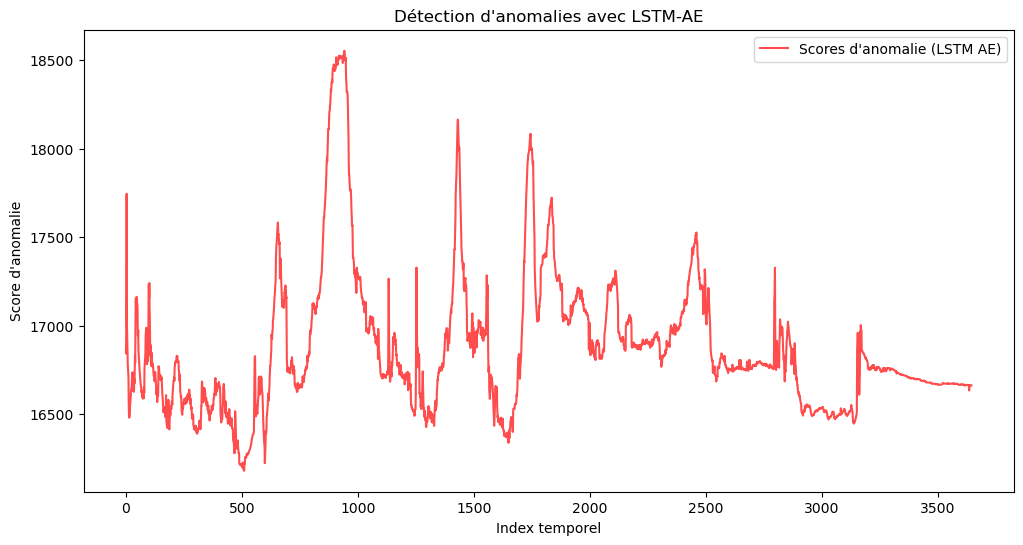

array([[16843.256],
       [16905.773],
       [17165.062],
       ...,
       [16661.416],
       [16661.37 ],
       [16661.469]], dtype=float32)

In [54]:
# On suppose que X_train_tensor et X_test_tensor sont déjà définis et ont la forme (N, T, D)
tester = LSTMAETester(X_train_tensor, X_test_tensor)
tester.optimize_hyperparameters()
tester.test_model()
tester.plot_anomaly_scores()

X_test_tensor shape: torch.Size([3647, 50, 49])
X_test_tensor transposé shape: torch.Size([50, 3647, 49])
Inputs type: <class 'tuple'>
Inputs shape: torch.Size([32, 50, 49])
Targets shape: torch.Size([32, 50, 49])
Les attributs 'mean' et 'precision' sont correctement initialisés.
Sortie pour tenseur synthétique : torch.Size([32, 50, 49])
Dernier pas de sortie : torch.Size([32, 49])
test_outputs shape: torch.Size([3647, 50, 49])
last_test_outputs shape: torch.Size([3647, 49])
last_targets shape: torch.Size([3647, 49])
Loss sur l'ensemble de test : 1.9612764120101929


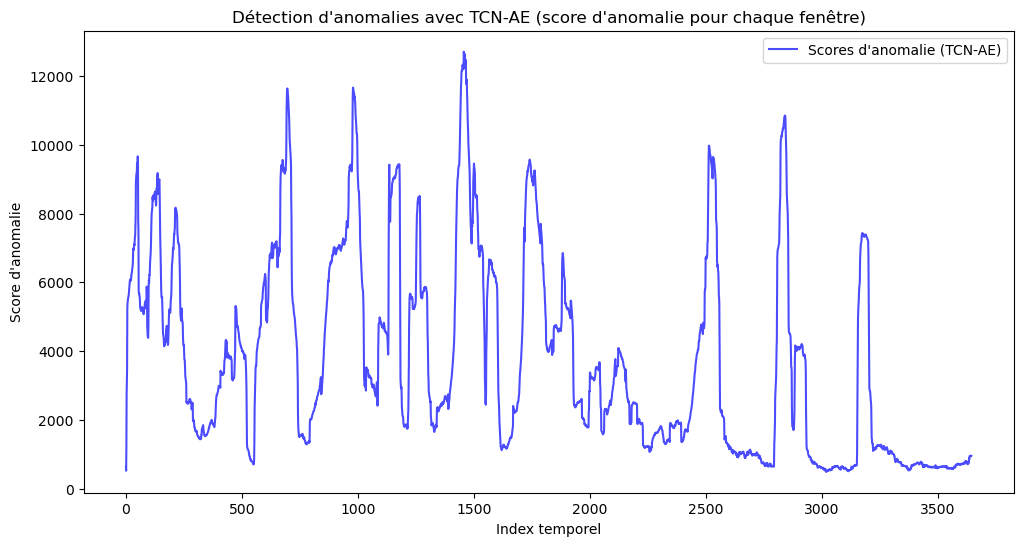

In [55]:
# TEST TCN-AE

print("X_test_tensor shape:", X_test_tensor.shape)
print("X_test_tensor transposé shape:", X_test_tensor.transpose(0, 1).shape)

# Récupérer la dimension d'entrée
input_dim = X_train_tensor.shape[-1]  

# Instancier le modèle TCN-AE et le détecteur associé
model = TCNAEAnomalyDetector(TCNAE(input_dimension=input_dim))

# Définir une fonction de collate personnalisée (sans transposition)
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)  # (B, T, D)
    ys = torch.stack(ys)  # (B, T, D)
    return (xs,), (ys,)

# Créer le DataLoader avec la fonction collate
train_loader = DataLoader(
    TensorDataset(X_train_tensor, X_train_tensor),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

# Vérifier un batch d'exemple
sample_batch = next(iter(train_loader))
inputs, targets = sample_batch
print("Inputs type:", type(inputs))         # Devrait être un tuple
print("Inputs shape:", inputs[0].shape)      # Attendu : (B, T, D)
print("Targets shape:", targets[0].shape)     # Attendu : (B, T, D)

# Entraîner le modèle
model.fit(train_loader)
if not hasattr(model, 'mean') or not hasattr(model, 'precision'):
    print("Erreur : Les attributs 'mean' et 'precision' ne sont pas définis.")
else:
    print("Les attributs 'mean' et 'precision' sont correctement initialisés.")

# Fonction pour obtenir la reconstruction complète via teacher forcing
def full_sequence_forward(model, x):
    with torch.no_grad():
        out = model.model((x,))
    return out

# Test sur un tenseur synthétique (attention : pour TCN-AE, la forme attendue est (B, T, D))
B, T, D = 32, 50, input_dim
x_test = torch.rand(B, T, D)
output = full_sequence_forward(model, x_test)
print("Sortie pour tenseur synthétique :", output.shape)
if output.dim() > 0:
    last_output = output[:, -1, :]  # Extraire le dernier pas pour chaque exemple du batch
    print("Dernier pas de sortie :", last_output.shape)

# Fonction de test sur l'ensemble de test
def test_model(model, test_data):
    criterion = nn.MSELoss()
    with torch.no_grad():
        test_outputs = full_sequence_forward(model, test_data)
    
    print("test_outputs shape:", test_outputs.shape)
    last_test_outputs = test_outputs[:, -1, :]
    print("last_test_outputs shape:", last_test_outputs.shape)
    last_targets = test_data[:, -1, :]
    print("last_targets shape:", last_targets.shape)
    test_loss = criterion(last_test_outputs, last_targets).item()
    print(f"Loss sur l'ensemble de test : {test_loss}")

test_model(model, X_test_tensor)

# Détection d'anomalies : calcul d'un score d'anomalie pour chaque fenêtre de X_test_tensor
anomaly_scores = []
for i in range(len(X_test_tensor)):
    # Préparer chaque fenêtre avec la forme (1, T, D)
    window = X_test_tensor[i].unsqueeze(0)
    # Calculer le score d'anomalie
    score = model.compute_online_anomaly_score((window,)).detach().cpu().numpy()
    anomaly_scores.append(score)

anomaly_scores = np.array(anomaly_scores)

plt.figure(figsize=(12, 6))
plt.plot(anomaly_scores, label="Scores d'anomalie (TCN-AE)", color="blue", alpha=0.7)
plt.title("Détection d'anomalies avec TCN-AE (score d'anomalie pour chaque fenêtre)")
plt.xlabel("Index temporel")
plt.ylabel("Score d'anomalie")
plt.legend(loc="upper right")
plt.show()

In [40]:
#TEST OMNI ANOMALY (TRES LONG DONC MASQUE)

'''
Pour réduire davantage ce temps d'exécution, voici quelques suggestions complémentaires :

• Réduire encore le nombre d'échantillons Monte Carlo
Si vous passez par 4 échantillons, vous pouvez expérimenter avec 2 ou même 1 échantillon, au risque d'une estimation moins précise.

• Optimisation par vectorisation
Vérifiez si certaines boucles internes (par exemple dans le filtre de Kalman ou dans le traitement de normalizing flow) peuvent être davantage vectorisées pour réduire le surcoût des itérations en Python.

• Utiliser TorchScript plus largement
Vous pouvez essayer de compiler l'ensemble du modèle (pas uniquement detector.model) avec TorchScript pour réduire l'overhead de Python sur CPU.

• Profilage et optimisation spécifique
Il peut être utile de profiler votre code pour identifier précisément les parties les plus coûteuses et optimiser uniquement ces sections.

Ces ajustements devraient vous permettre de réduire davantage le temps d'exécution, mais gardez à l'esprit que les modèles complexes comme OmniAnomaly restent gourmands en ressources sur CPU par rapport à une exécution sur GPU.

'''

# Limiter le nombre de threads CPU pour optimiser les performances
torch.set_num_threads(4)

# Supposons que X_train_tensor et X_test_tensor soient déjà définis
input_dim = X_train_tensor.shape[-1]  # Dernière dimension du tenseur

print("X_test_tensor shape:", X_test_tensor.shape)
print("X_test_tensor transposé shape:", X_test_tensor.transpose(0, 1).shape)

input_dim = X_train_tensor.shape[-1]  # Dernière dimension du tenseur

# Création du modèle OmniAnomaly et du détecteur associé
model_omni = OmniAnomaly(input_dim=input_dim, latent_dim=3)  # latent_dim par défaut à 3
# Réduire num_mc_samples de 128 à 16 pour accélérer le calcul
detector = OmniAnomalyDetector(model_omni, num_mc_samples=2)

# ----- Définir une fonction de collate personnalisée -----
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs).transpose(0, 1)  # (T, B, D)
    ys = torch.stack(ys).transpose(0, 1)  # (T, B, D)
    return (xs,), (ys,)

# ----- Créer le DataLoader -----
train_loader = DataLoader(
    TensorDataset(X_train_tensor, X_train_tensor),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

# Affichage d'un échantillon pour vérifier les dimensions
sample_batch = next(iter(train_loader))
inputs, targets = sample_batch
print("Inputs type:", type(inputs))       # Doit être un tuple
print("Inputs shape:", inputs[0].shape)    # Devrait afficher (T, B, D)
print("Targets shape:", targets[0].shape)   # Devrait afficher (T, B, D)

# ----- Boucle d'entraînement pour OmniAnomaly -----
loss_fn = OmniAnomalyLoss()
optimizer = torch.optim.Adam(model_omni.parameters(), lr=1e-3)
num_epochs = 1  # Pour un test rapide

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        # Utiliser un nombre réduit d'échantillons MC pour accélérer l'entraînement
        outputs = model_omni(inputs, num_samples=16)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# ----- Test sur un tenseur synthétique -----
T, B, D = 50, 32, input_dim
x_test = torch.rand(T, B, D)
with torch.no_grad():
    anomaly_score_synth = detector.compute_online_anomaly_score((x_test,))
print("Anomaly score sur tenseur synthétique:", anomaly_score_synth)

# ----- Détection d'anomalies sur X_test_tensor -----
anomaly_scores = []
for i in range(len(X_test_tensor)):
    # Préparer chaque fenêtre avec la forme (T, 1, D)
    window = X_test_tensor[i].unsqueeze(0).transpose(0, 1)
    with torch.no_grad():
        score = detector.compute_online_anomaly_score((window,)).detach().cpu().numpy()
    anomaly_scores.append(score)
anomaly_scores = np.array(anomaly_scores)

plt.figure(figsize=(12, 6))
plt.plot(anomaly_scores, label="Scores d'anomalie (OmniAnomaly)", color="blue", alpha=0.7)
plt.title("Détection d'anomalies avec OmniAnomaly")
plt.xlabel("Index temporel")
plt.ylabel("Score d'anomalie")
plt.legend(loc="upper right")
plt.show()


'\nPour réduire davantage ce temps d\'exécution, voici quelques suggestions complémentaires\u202f:\n\n• Réduire encore le nombre d\'échantillons Monte Carlo\nSi vous passez par 4 échantillons, vous pouvez expérimenter avec 2 ou même 1 échantillon, au risque d\'une estimation moins précise.\n\n• Optimisation par vectorisation\nVérifiez si certaines boucles internes (par exemple dans le filtre de Kalman ou dans le traitement de normalizing flow) peuvent être davantage vectorisées pour réduire le surcoût des itérations en Python.\n\n• Utiliser TorchScript plus largement\nVous pouvez essayer de compiler l\'ensemble du modèle (pas uniquement detector.model) avec TorchScript pour réduire l\'overhead de Python sur CPU.\n\n• Profilage et optimisation spécifique\nIl peut être utile de profiler votre code pour identifier précisément les parties les plus coûteuses et optimiser uniquement ces sections.\n\nCes ajustements devraient vous permettre de réduire davantage le temps d\'exécution, mais gar

In [82]:
#RENVOIE LES MEILLEURS PARAMETRES POUR ENTRAINER TCN AE (ne fonctionne pas)
class TCNAEOptimizer:
    def __init__(self, X_train, X_test, num_epochs=5, batch_size=32, lr=1e-3, param_grid=None):
        """
        Initialise l'optimiseur pour le modèle TCN-AE.

        Parameters
        ----------
        X_train : torch.Tensor
            Tenseur d'entraînement de forme (N, T, D)
        X_test : torch.Tensor
            Tenseur de test de forme (N, T, D)
        num_epochs : int, optional
            Nombre d'époques pour l'entraînement (par défaut 5)
        batch_size : int, optional
            Taille de batch pour les DataLoaders (par défaut 32)
        lr : float, optional
            Taux d'apprentissage pour l'optimiseur Adam (par défaut 1e-3)
        param_grid : dict, optional
            Grille d'hyperparamètres à tester. Si None, une grille par défaut est utilisée.
        """
        self.X_train = X_train
        self.X_test = X_test
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        if param_grid is None:
            self.param_grid = {
                'kernel_size': [15],
                'dilations': [(1, 2)],
                'nb_filters': [16, 32],
                'dropout_rate': [0.0, 0.2]
            }
        else:
            self.param_grid = param_grid
            

    @staticmethod
    def collate_fn_tcn(batch):
        """
        Fonction de regroupement pour TCN-AE : conserve le format (B, T, D)
        """
        xs, ys = zip(*batch)
        xs = torch.stack(xs)  # (B, T, D)
        ys = torch.stack(ys)  # (B, T, D)
        return (xs,), (ys,)

    def optimize(self):
        """
        Parcourt la grille d'hyperparamètres, entraîne et évalue le modèle TCN-AE pour chaque combinaison,
        et retourne le modèle avec la meilleure perte ainsi que ses hyperparamètres.

        Returns
        -------
        best_model : TCNAE
            Le modèle TCN-AE ayant obtenu la meilleure perte sur le jeu de test.
        best_params : dict
            Les hyperparamètres correspondant au meilleur modèle.
        """
        best_loss = float('inf')
        best_params = None
        best_model = None
        collate_fn = TCNAEOptimizer.collate_fn_tcn

        # Parcours de toutes les combinaisons d'hyperparamètres
        for params in itertools.product(*self.param_grid.values()):
            param_dict = dict(zip(self.param_grid.keys(), params))
            start_time = time.time()

            # Ajuster latent_sample_rate pour qu'il ne dépasse pas la longueur de la séquence (X_train est (N, T, D))
            latent_sample_rate = min(self.X_train.shape[1], 42)
            current_model = TCNAE(
                input_dimension=self.X_train.shape[-1],
                latent_sample_rate=latent_sample_rate,
                **param_dict
            )
            # Désactive les opérations inplace pour éviter les erreurs de gradient

            # Création des DataLoaders (les tenseurs sont au format (B, T, D))
            train_loader = DataLoader(
                TensorDataset(self.X_train, self.X_train),
                batch_size=self.batch_size,
                shuffle=True,
                collate_fn=collate_fn
            )
            test_loader = DataLoader(
                TensorDataset(self.X_test, self.X_test),
                batch_size=self.batch_size,
                collate_fn=collate_fn
            )

            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(current_model.parameters(), lr=self.lr)

            # Entraînement
            current_model.train()
            for epoch in range(self.num_epochs):
                for batch, _ in train_loader:
                    # Pour TCN-AE, batch[0] est de forme (B, T, D) et le forward attend un tuple contenant ce tenseur.
                    x = batch[0] if isinstance(batch, tuple) else batch
                    optimizer.zero_grad()
                    output = current_model((x,))
                    loss = criterion(output, x)
                    loss.backward()
                    optimizer.step()

            # Évaluation
            current_model.eval()
            total_loss = 0
            with torch.no_grad():
                for batch, _ in test_loader:
                    x = batch[0] if isinstance(batch, tuple) else batch
                    output = current_model((x,))
                    total_loss += criterion(output, x).item()
            test_loss = total_loss / len(test_loader)
            elapsed_time = time.time() - start_time

            print(f"Test Loss (TCN) avec {param_dict} : {test_loss:.4f} (Temps: {elapsed_time:.2f} sec)")

            if test_loss < best_loss:
                best_loss = test_loss
                best_params = param_dict
                best_model = current_model

        print(f"Meilleurs hyperparamètres pour TCN: {best_params} avec Loss {best_loss:.4f}")
        return best_model, best_params

In [83]:
# Supposons que X_train_tensor et X_test_tensor soient vos tenseurs d'entraînement et de test de forme (N, T, D)
optimizer = TCNAEOptimizer(X_train_tensor, X_test_tensor, num_epochs=5, batch_size=32, lr=1e-3)
best_tcn_model, best_tcn_params = optimizer.optimize()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 16, 50]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!